In [1]:
import os
from typing import  List
from pydantic import BaseModel, Field
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
import sqlite3

from yaml import load
from yaml import SafeLoader
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langgraph.prebuilt import ToolNode
from langchain_core.messages import ToolMessage
import json
import logging
from io import BytesIO
from typing import Annotated, Literal
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

from typing_extensions import TypedDict
import openai
from typing import Optional
os.environ["OPENAI_API_KEY"] = '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'

In [2]:
from langchain_core.prompts import ChatPromptTemplate




In [316]:
#make a judge a node

In [3]:
INITIAL_PROMPT = """
You are a professional fitness coach.

Your mission is to help people reach their fitness goals by:
- Analyzing their current fitness level, body weghit and height

WEGHIT:{weight}
HEIGHT:{tall}
GOAL:{goal}
intensity:{intensity}
age:{age}
sex:{sex}
Equipment: local gym


1.Use your knowledge and tools to search for relevant exercises from a database
   and determine optimal sets, reps, and intensity based on the user's goals.
   search one primary muscle group and one sub-muscle group at a time.
2. Organize the workout into a structured, goal-specific plan, categorized by
   body parts (e.g., back, chest, legs) and sub-muscle groups.
3. Allow for feedback, adjustments, and improvements based on user input or
   progress tracking.
4. Output the full program in a clean, structured format that includes:
   - Exercises with primary/secondary muscle groups
   - Instructions, sets, reps, and variations
   - Weekly split and progression strategies
NOTIFIY THE USER WHETHER THE DATABASE RETUREND THE CORRECT ANSWER OR NOT
IMPORTANT:
- Avoid repeating the same movement pattern within a body part.
- Prioritize **variety** and **muscle group balance**.
- Rotate between compound and isolation exercises, machines and free weights, unilateral and bilateral movements.
- Focus on muscle groups from the following comprehensive lists:
Body parts: Back, Chest, Leg, Shoulders, Arms
THIS the list of all the primary mucsle names
:[
    'Biceps Brachii', 'Brachialis', 'Brachioradialis', 'Deltoid', 'Gluteus Maximus', 'Hamstrings',
    'Deltoid Lateral', 'biceps', 'brachialis', 'brachioradialis', 'chest', 'Anterior Deltoids',
    'Lateral Deltoids', 'Triceps Brachii', 'Upper Pectorals', 'Pectoralis Major', 'Triceps',
    'Latissimus Dorsi', 'Trapezius', 'Rhomboids', 'Deltoids', 'biceps femoris', 'semitendinosus',
    'semimembranosus', 'quads', 'glutes', 'Chest', 'Shoulders', 'Core', 'Rear Deltoids',
    'Rotator Cuff', 'Posterior Deltoids', 'Quadriceps', 'Hips', 'Gluteal muscles', 'Front Deltoids',
    'Lateral Deltoid', 'Rear Deltoid', 'Pectoralis', 'Pectoralis major', 'Erector Spinae',
    'adductors', 'inner thigh muscles', 'Lower Back', 'Middle Back', 'Gastrocnemius', 'Soleus',
    'lower back', 'Gluteus Medius', 'Gluteus Minimus', 'calves', 'Spinal Erectors',
    'forearm extensors', 'back', 'Pectoral muscles', 'Chest muscles', 'Medial Deltoid',
    'Serratus Anterior', 'Middle delts', 'Rear delts', 'Traps', 'Rectus Femoris', 'Vastus Medialis',
    'Back muscles', 'forearm muscles', 'latissimus dorsi', 'Wrist Flexor', 'Wrist Flexors',
    'Lateral Deltoids', 'Posterior Deltoids', 'Latissimus dorsi', 'Lower trapezius',
    'Pectoralis Minor', 'Pectoralis Major - Clavicular Head', 'Multifidus', 'lats', 'traps',
    'Vastus Lateralis', 'Vastus Intermedius', 'legs', 'Upper Back', 'Middle Trapezii',
    'Lower Trapezii', 'Teres Major', 'Teres Minor', 'Infraspinatus', 'delts', 'pecs',
    'Thenar muscles', 'Finger Flexors', 'Pectoral (Chest) Muscles'
]

THIS the list of all the secondary mucsle names
'abdominal muscles', 'abdominals', 'abductors', 'abs', 'adductor brevis', 'adductor longus', 'adductor magnus', 'adductors', 'ankle stabilizers', 
'anterior deltoid', 'anterior deltoids', 'arm muscles', 'arms', 'back', 'back muscles', 'biceps', 'biceps brachii', 'brachialis', 'brachioradialis',
'branchialis', 'calf muscles', 'calves', 'chest', 'core', 'core muscles', 'core musculature', 'deep core muscles', 'deltoids', 'elbow flexors', 'erector
spinae', 'erectors', 'external oblique', 'external obliques', 'forearm', 'forearm flexors', 'forearm flexors and extensors', 'forearm muscles', 'forearms',
'gastrocnemius', 'gluteus maximus', 'glutes', 'grip muscles', 'hamstrings', 'hands', 'hip flexors', 'hips', 'infraspinatus', 'inner thighs', 'lateral deltoid', 'lateral deltoids', 'lats', 'legs', 
'levator scapulae', 'lower back', 'lower back muscles', 'lower leg', 'lower traps', 'multifidus', 'neck', 'obliques', 'outer thighs', 'pecs', 'posterior deltoids',
'posterior delts', 'posterior oblique sling', 'postural muscles', 'quadriceps', 'quads', 'rear deltoids', 'rectus abdominis', 'rhomboid major', 'rhomboid minor',
'rhomboids', 'rotator', 'rotator cuff muscles', 'scapular', 'serratus anterior', 'shoulder stabilizers', 'shoulders', 'soleus', 'spinal erectors', 
'stabilizing muscles', 'teres major', 'teres minor', 'thighs', 'tibialis anterior', 'transverse abdominis', 'trapezius', 'traps', 'triceps',
'triceps brachii', 'upper back', 'upper back muscles', 'upper body', 'upper chest', 'upper pectoralis', 'upper traps', 'wrist extensor', 
'wrist extensors', 'wrist flexors'
"""


In [4]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        message.pretty_print()

In [5]:
config = load(open("config.yaml"), Loader=SafeLoader)
os.environ["GROQ_API_KEY"] = config["groq"]["apiKey"]
from langchain_groq import ChatGroq


In [ ]:
from langchain.tools import tool
connection = sqlite3.connect("work_out.db")
@tool
def get_exercises(body_part: str, primary_muscles: str, secondary_muscles: str) -> list:
    """
    Fetches exercises from the SQLite database based on primary and sub muscle.

    Args:
        body_part (str): The body part to filter exercises by.
        primary_muscles (str): Primary muscle group targeted.
        secondary_muscle (str): Secondary muscle group targeted.

    
    Returns:
        str: A formatted string listing matching exercises, one per line.
    """
    primary_muscles = primary_muscles.lower().strip()
    secondary_muscles = secondary_muscles.lower().strip()
    body_part = body_part.lower().strip()
    body_part_modified = body_part[:-1] if body_part.endswith('s') else body_part

    connection = sqlite3.connect("work_out.db")
    cursor = connection.cursor()
    query = f"""
        SELECT primary_muscles,secondary_muscles 
        FROM DATASET
        WHERE (primary_muscles LIKE '%{primary_muscles}%' 
               OR secondary_muscles LIKE '%{secondary_muscles}%')
        AND body_part = '{body_part_modified}'
        LIMIT 10;
    """
    parameters = (f"%{primary_muscles}%", f"%{secondary_muscles}%", body_part_modified)
    cursor.execute(query)
    rows = cursor.fetchall()
    connection.close()
    if not rows:
        return "no exercises found"
    exercises = []
    for i, (name, prim, sec) in enumerate(rows, 1):
        exercises.append(
            f"{i}. {name}\n   Primary: {prim}\n   Secondary: {sec}"
        )
    # Format as a numbered list
    exercises2 = "\n".join([f"{i+1}. {row[0]}" for i, row in enumerate(rows)])
    return f"Found these exercises:\n{exercises2}"
    
    


In [321]:
connection = sqlite3.connect("work_out.db")
cursor = connection.cursor()
query = """
    SELECT DISTINCT body_part
    FROM DATASET

"""
cursor.execute(query)
rows = cursor.fetchall()
connection.close()

In [322]:
print(rows)

[('arm',), ('leg',), ('shoulder',), ('back',), ('chest',)]


In [7]:
get_exercises.invoke({"body_part": "arm", "primary_muscles": "Biceps ", "secondary_muscles": "Brachialis"})

'Found these exercises:\n1. Barbell Bicep Curl\n2. Dumbbell Bicep Curl\n3. Hammer Curl\n4. Incline Dumbbell Curl\n5. Concentration Curl\n6. Preacher Curl\n7. Cable Bicep Curl\n8. Reverse Curl (Barbell or Dumbbell)\n9. EZ Bar Curl\n10. Zottman Curl'

In [324]:
tools=[get_exercises]

In [325]:

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.1,
    max_tokens=None,
    timeout=None,
    max_retries=2,
).bind_tools(tools)

In [326]:

llm=llm.bind_tools(tools)

In [327]:
tool_node=ToolNode(tools)

In [328]:
class State(TypedDict):
    messages: Annotated[list,add_messages]
    summary_plan: str

In [329]:
# def should_continue(state: State) -> Literal["tools", "summary"]:  # Changed "summary" to "end"
#     messages = state["messages"]
#     last_message = messages[-1]
    
#     # Only continue to tools if there are active tool calls
#     if hasattr(last_message, "tool_calls") and last_message.tool_calls:
#         return "tools"
#     return   "summary"



In [330]:
def should_continue(state: State) -> Literal["tools", END]:  # Changed "summary" to "end"
    messages = state["messages"]
    last_message = messages[-1]
    
    # Only continue to tools if there are active tool calls
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    return END  



In [331]:
summary_prompt = """ Summarize the workout plan in a nice and clean format"""

In [332]:
llm2=ChatOpenAI(model="google/gemini-2.5-pro-exp-03-25:free",base_url="https://openrouter.ai/api/v1")



In [333]:
llm=llm2.bind_tools(tools)

In [334]:
llm.invoke("what exercises traget chest and biceps")

AIMessage(content="Okay, I can search for exercises. However, it's quite uncommon for a single exercise to strongly target both the chest as a primary mover and the biceps as a significant secondary mover (or vice-versa). Chest exercises typically involve the triceps and shoulders, while bicep exercises usually involve forearm muscles.\n\nWould you like me to search for:\n1.  Exercises where the **chest is primary** and **biceps are secondary**?\n2.  Exercises where the **biceps are primary** and **chest is secondary**?\n3.  Or, would you prefer separate lists: one for exercises primarily targeting the **chest**, and another list for exercises primarily targeting the **biceps**?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 145, 'prompt_tokens': 110, 'total_tokens': 1640, 'completion_tokens_details': None}, 'model_name': 'google/gemini-2.5-pro-exp-03-25', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-732

In [335]:
def call_model(state: State):
    
    print("you are in call model ")
    messages = state["messages"]
    
    
    for i, msg in enumerate(messages):
        if isinstance(msg, ToolMessage) and not isinstance(msg.content, str):
            messages[i] = ToolMessage(
                tool_call_id=msg.tool_call_id,
                content=json.dumps(msg.content)
            )


    response = llm.invoke(messages)
    return {"messages": [response]}

In [336]:
def summary_node(state: State):
    print("you are in summary ")
    messages = state["messages"]
    messages.append( summary_prompt)
    summarize =llm.invoke(messages)
    print("you are near end ")

    return {
        "messages": messages,
        "summary_plan": summarize,
    }

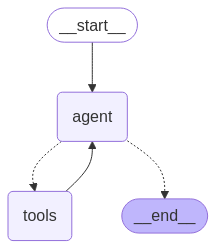

In [337]:
workflow = StateGraph(State)
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
#workflow.add_node("summary", summary_node)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue)
workflow.add_edge("tools", "agent")
#workflow.add_edge("summary", END)
checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [338]:
INITIAL_PROMPT=INITIAL_PROMPT.format(weight=90, tall=180,goal="get lean muscle",sex="male",age=25,intensity="high")

In [339]:
from langchain_core.runnables.config import RunnableConfig


In [340]:
config = {
    "configurable": {
        "thread_id": 17
    }
}


In [341]:
config = RunnableConfig(thread_id=78,recursion_limit=50)

In [342]:
inputs = {"messages": [("user", INITIAL_PROMPT)]}
print_stream(graph.stream(inputs, config, stream_mode="values"))
# Start chatbot


================================ Human Message =================================


You are a professional fitness coach.

Your mission is to help people reach their fitness goals by:
- Analyzing their current fitness level, body weghit and height

WEGHIT:90
HEIGHT:180
GOAL:get lean muscle
intensity:high
age:25
sex:male
Equipment: local gym


1.Use your knowledge and tools to search for relevant exercises from a database
   and determine optimal sets, reps, and intensity based on the user's goals.
   search one primary muscle group and one sub-muscle group at a time.
2. Organize the workout into a structured, goal-specific plan, categorized by
   body parts (e.g., back, chest, legs) and sub-muscle groups.
3. Allow for feedback, adjustments, and improvements based on user input or
   progress tracking.
4. Output the full program in a clean, structured format that includes:
   - Exercises with primary/secondary muscle groups
   - Instructions, sets, reps, and variations
   - Weekly split 

ValueError: {'message': 'Internal Server Error', 'code': 500}

In [ ]:
get_exercises.invoke({"body_part": "Arm", "primary_muscles": "Quadriceps", "secondary_muscles": "Hamstrings"})

'Found these exercises:\n1. Kickbacks (Dumbbell or Cable)\n2. Farmer’s Carry'

In [ ]:


# while True:
#     user_input = input("User: ")
#     inputs = {"messages": [("user", user_input)]}
#     print_stream(graph.stream(inputs, config, stream_mode="values"))

In [ ]:
graph.get_state(config).values["summary_plan"].content

KeyError: 'summary_plan'

In [ ]:
import os
import subprocess

# Define LaTeX content
latex_code = r"""
\documentclass{article}
\usepackage{amsmath}
\usepackage[margin=1in]{geometry}
\begin{document}

\section*{4-Day Workout Plan}

\subsection*{Day 1: Chest and Triceps}
\begin{itemize}
    \item \textbf{Barbell Bench Press (3 sets of 8--12 reps)}\\
    Primary: Pectoralis Major, Secondary: Triceps
    \item \textbf{Incline Dumbbell Press (3 sets of 10--15 reps)}\\
    Primary: Pectoralis Major, Secondary: Anterior Deltoids
    \item \textbf{Tricep Pushdown (3 sets of 12--15 reps)}\\
    Primary: Triceps
    \item \textbf{Overhead Dumbbell Extension (3 sets of 12--15 reps)}\\
    Primary: Triceps
\end{itemize}

\subsection*{Day 2: Back and Biceps}
\begin{itemize}
    \item \textbf{Pull-ups (3 sets of 8--12 reps)}\\
    Primary: Latissimus Dorsi, Secondary: Biceps
    \item \textbf{Barbell Rows (3 sets of 8--12 reps)}\\
    Primary: Latissimus Dorsi, Secondary: Trapezius
    \item \textbf{Dumbbell Bicep Curls (3 sets of 10--12 reps)}\\
    Primary: Biceps
    \item \textbf{Hammer Curls (3 sets of 10--12 reps)}\\
    Primary: Biceps
\end{itemize}

\subsection*{Day 3: Legs}
\begin{itemize}
    \item \textbf{Squats (3 sets of 8--12 reps)}\\
    Primary: Quadriceps, Secondary: Hamstrings
    \item \textbf{Leg Press (3 sets of 10--12 reps)}\\
    Primary: Quadriceps, Secondary: Hamstrings
    \item \textbf{Lunges (3 sets of 10--12 reps per leg)}\\
    Primary: Quadriceps, Secondary: Hamstrings
    \item \textbf{Leg Extensions (3 sets of 12--15 reps)}\\
    Primary: Quadriceps
\end{itemize}

\subsection*{Day 4: Shoulders and Abs}
\begin{itemize}
    \item \textbf{Standing Military Press (3 sets of 8--12 reps)}\\
    Primary: Deltoids, Secondary: Triceps
    \item \textbf{Lateral Raises (3 sets of 10--12 reps)}\\
    Primary: Deltoids
    \item \textbf{Reverse Fly (3 sets of 12--15 reps)}\\
    Primary: Deltoids
    \item \textbf{Plank (3 sets of 30--60 seconds)}\\
    Primary: Rectus Abdominis, Secondary: Obliques
\end{itemize}

\end{document}
"""

# Save LaTeX content to file
with open("output.tex", "w", encoding="utf-8") as f:
    f.write(latex_code)

# Run pdflatex in the current directory
import subprocess

# Full path to pdflatex
pdflatex_path = r"C:\Users\Hossa\AppData\Local\Programs\MiKTeX\miktex\bin\x64\pdflatex.exe"

# Compile the LaTeX file
subprocess.run([pdflatex_path, "output.tex"], check=True)


CompletedProcess(args=['C:\\Users\\Hossa\\AppData\\Local\\Programs\\MiKTeX\\miktex\\bin\\x64\\pdflatex.exe', 'output.tex'], returncode=0)

: 

In [ ]:
class State(TypedDict):
    messages: Annotated[list,add_messages]

In [ ]:
class single_exercise(BaseModel):
    exercise: str = Field(description="exercise name")
    sub_muscles: list [str] = Field(description="list of sub_muscle in this exercise")
    primary_muscles:list [ str] = Field(description="list of primary muscle in this exercise")
    sets :str = Field(description="number of sets")
    reps: str = Field(description="number of reps")
    instruction: str = Field(description="exercise instruction")
    @property
    def summary(self):
        return f"sub_muscle: {self.sub_muscle}, exercise: {self.exercise}, sets: {self.sets}, reps: {self.reps}, details: {self.details}"
class single_body_part(BaseModel):
    body_part: str = Field(description="name of the body part")
    exercises: List[single_exercise] = Field(description="list of exercises in this body part")
    @property
    def summary(self):
        return f"body_part: {self.body_part}, exercises: {self.exercises}"
#structed_output_llm=llm.with_structured_output(single_body_part)

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

# Define the prompt template with proper input variables
fitness_instructions = ChatPromptTemplate.from_template("""
You are tasked with generating a list of exercises for {body_part} that the user needs to train. Follow these instructions carefully:

1. First, review the Goal: {Goal} and the height and weight of {tall}cm and {weight}kg then specify the level of {the_level_of_cardio}.
    
2. Examine any editorial feedback: {human_feedback}

3. Take notes on the level of {intensity}

4. You can search the database for exercises by using tools

{input}
{agent_scratchpad}""")  # Required for tool calling

# Construct the tool calling agent
agent = create_tool_calling_agent(
    llm=llm,
    tools=tools,
    prompt=fitness_instructions
)

In [ ]:
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True,max_iterations=3)

response = agent_executor.invoke({
    "body_part": "back",
    "Goal": "gain muscle",
    "intensity": "moderate",
    "tall": 180,
    "weight": 70,
    "the_level_of_cardio": "medium",
    "human_feedback": "",
    "input": "Generate workout exercises for back",
})



> Entering new AgentExecutor chain...

Invoking: `get_exercises` with `{'body_part': 'back', 'primary_muscles': 'latissimus dorsi', 'secondary_muscles': 'trapezius'}`


['Chin-Ups', 'Behind-the-Neck Pulldown']
Invoking: `get_exercises` with `{'body_part': 'back', 'primary_muscles': 'latissimus dorsi', 'secondary_muscles': 'trapezius'}`


['Chin-Ups', 'Behind-the-Neck Pulldown']
Invoking: `get_exercises` with `{'body_part': 'back', 'primary_muscles': 'latissimus dorsi', 'secondary_muscles': 'trapezius'}`


['Chin-Ups', 'Behind-the-Neck Pulldown']

> Finished chain.


In [ ]:
response

{'body_part': 'back',
 'Goal': 'gain muscle',
 'intensity': 'moderate',
 'tall': 180,
 'weight': 70,
 'the_level_of_cardio': 'medium',
 'human_feedback': '',
 'input': 'Generate workout exercises for back',
 'output': 'Agent stopped due to max iterations.'}

In [ ]:
class Generate_plans(TypedDict):
    goal:str # goal of the workout_plans
    intensity: str # intensity of the workout
    tall: int 
    weight: int
    human_feedback: str
    max_exercises: int
    muscle_workouts: List[MainMuscle] # list of whole body exercise

In [ ]:
import langchain_core

In [ ]:
fitness_instructions="""You are tasked with retreiving and review a set of exercises for each muscle group. Follow these instructions carefully:

1. First, review the research topic:
{goal}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
{human_feedback}
3. take notes on the level of {intensity} and / or feedback above.
4. Assign one set of exercises to each main muscle group.
5. Pick the top {max_exercises} exercises for each SUB muscle group."""


In [ ]:
def create_plans(state: Generate_plans):
    
    """ Create plans """
    print("i am here")
    goal=state.get('goal', '')
    intensity=state.get('intensity', '')
    human_feedback=state.get('human_feedback', '')
    max_exercises=state.get('max_exercises', 0)    
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = fitness_instructions.format(goal=goal,
                                                            human_feedback=human_feedback, 
                                                            intensity=intensity,max_exercises=max_exercises)

    # Generate question 
    main_muscle_plans = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="serach the set of exercises with serach_by_sub_muscle_tool and enhance it.")])
    
    # Write the list of analysis to state
    return {"muscle_workouts": main_muscle_plans}

In [ ]:
def search_exercises(main: str = None, sub: str = None):
    cursor = connection.cursor()
    cursor.execute(
        """
        SELECT * 
        FROM exercises
        WHERE sub_muscles LIKE ?
        OR main_muscle LIKE ?;
        """,
        (f"%{sub}%", f"%{main}%")
    )
    rows = cursor.fetchall()
    print("I am here")
    # Display the results
    return rows


In [ ]:
def human_feedback_nod(state: Generate_plans):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: Generate_plans):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_feedback', None)
    if human_analyst_feedback:
        return "create_plans"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(Generate_plans)
builder.add_node("create_plans", create_plans)
builder.add_node("human_feedback_nod", human_feedback_nod)
builder.add_edge(START, "create_plans")
builder.add_edge("create_plans", "human_feedback_nod")
builder.add_conditional_edges("human_feedback_nod", should_continue, ["create_plans", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback_nod'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

NameError: name 'Generate_plans' is not defined

In [ ]:
# Input
max_exercises = 2
goal = "lose weight"
intessity = "high"
tall=178
weight=60
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"goal":goal,"max_exercises":max_exercises,"instensity":intessity}, thread, stream_mode="values"):
    # Review
    muscle_workouts = event.get('muscle_workouts', '')
    if muscle_workouts:
        for set in muscle_workouts:
            print(set)

i am here
('muscle_workouts', [{'main_muscle': 'Chest', 'sub_muscle': ['Pectoralis Major', 'Pectoralis Minor'], 'exercise': ['Bench Press', 'Dumbbell Press', 'Incline Press']}, {'main_muscle': 'Back', 'sub_muscle': ['Latissimus Dorsi', 'Trapezius'], 'exercise': ['Pull-ups', 'Lat Pulldowns', 'Rows']}, {'main_muscle': 'Legs', 'sub_muscle': ['Quadriceps', 'Hamstrings'], 'exercise': ['Squats', 'Lunges', 'Leg Press']}, {'main_muscle': 'Shoulders', 'sub_muscle': ['Deltoids', 'Rotator Cuff'], 'exercise': ['Shoulder Press', 'Lateral Raises', 'Rear Delt Fly']}, {'main_muscle': 'Arms', 'sub_muscle': ['Biceps', 'Triceps'], 'exercise': ['Bicep Curls', 'Tricep Pushdowns', 'Overhead Dumbbell Extension']}])


In [ ]:
state = graph.get_state(thread)
print(state)

StateSnapshot(values={'goal': 'lose weight', 'max_exercises': 2, 'muscle_workouts': Perspectives(muscle_workouts=[{'main_muscle': 'Chest', 'sub_muscle': ['Pectoralis Major', 'Pectoralis Minor'], 'exercise': ['Bench Press', 'Dumbbell Press', 'Incline Press']}, {'main_muscle': 'Back', 'sub_muscle': ['Latissimus Dorsi', 'Trapezius'], 'exercise': ['Pull-ups', 'Lat Pulldowns', 'Rows']}, {'main_muscle': 'Legs', 'sub_muscle': ['Quadriceps', 'Hamstrings'], 'exercise': ['Squats', 'Lunges', 'Leg Press']}, {'main_muscle': 'Shoulders', 'sub_muscle': ['Deltoids', 'Rotator Cuff'], 'exercise': ['Shoulder Press', 'Lateral Raises', 'Rear Delt Fly']}, {'main_muscle': 'Arms', 'sub_muscle': ['Biceps', 'Triceps'], 'exercise': ['Bicep Curls', 'Tricep Pushdowns', 'Overhead Dumbbell Extension']}])}, next=('human_feedback_nod',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efb9e79-7665-6672-8001-cbe35fa2ccc6'}}, metadata={'source': 'loop', 'writes': {'create_plans': {'mus